# 1. Import Data

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import time
import datetime

import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#load the SentimentIntensityAnalyser object in
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# assign it to another name to make it easier to use
analyzer = SentimentIntensityAnalyzer()

#import nltk
#nltk.download('punkt')

In [32]:
df = pd.read_csv("..//May Myo//raw_data//reviews.csv.gz")

# checking shape ...
print("The dataset has {} rows and {} columns.".format(*reviews.shape))

# ... and duplicates
print("It contains {} duplicates.".format(reviews.duplicated().sum()))

The dataset has 320628 rows and 6 columns.
It contains 0 duplicates.


In [33]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...


# 2. Preprocessing the Data

In [34]:
df.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         133
dtype: int64

In [31]:
df.dropna(inplace=True)
df.isna().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [41]:
df.shape

(320628, 6)

### 3. Detect Language used in comments

In [38]:
from langdetect import detect

In [39]:
# the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [40]:
%%time
df['language'] = reviews['comments'].apply(language_detection)

Wall time: 1h 2min 16s


In [42]:
df.language.value_counts().head(10)

en       298505
fr         6327
de         3648
es         2935
zh-cn      1878
ko         1553
ro          735
it          710
pt          535
nl          516
Name: language, dtype: int64

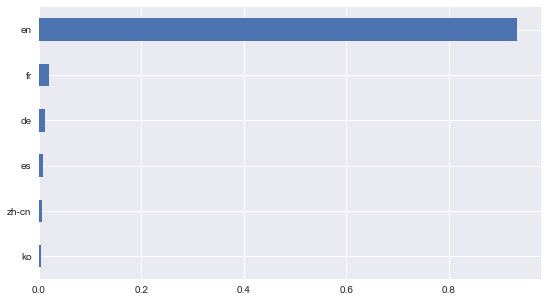

In [47]:
ax = df.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh', figsize=(9,5));

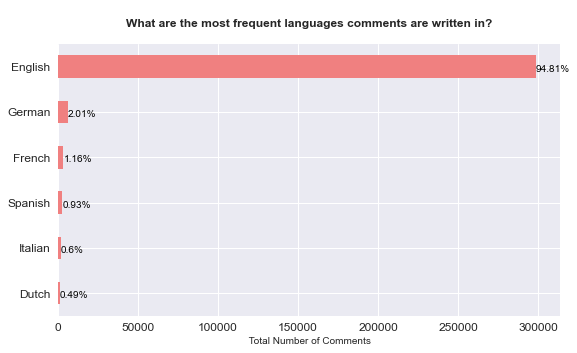

In [48]:
# visualizing the comments' languages b) neat and clean
ax = df.language.value_counts().head(6).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'German', 'French', 'Spanish', 'Italian', 'Dutch'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

In [64]:
# as we are only interested in comments written in english, we need to split the data to english related sub-dataframes
df_eng = df[(df['language']=='en')]

In [60]:
#save df_eng to pkl files to reduce loading time 
reviews=reviews.drop(['language'], axis=1)
df_eng.to_pickle("df_eng.pkl")

In [74]:
df_eng.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...


In [3]:
reviews = pd.read_pickle("df_eng.pkl")

In [26]:
#remove commens withs 3 alphaets and less
reviews["comments_cleansed"] = reviews.comments.str.replace(r'\b(\w{1,3})\b', '')

In [33]:
#Remove non-letters and change to lower case:
stemmer = PorterStemmer()
#remove stop words, tokenise the text data
stop_words = set(stopwords.words('english'))

def preprocess(review):
    review = " ".join([stemmer.stem(w.lower()) for w in word_tokenize(re.sub('[^a-zA-Z]+', ' ', review.replace("<br />", ""))) if not w in stop_words])
    return review

reviews['comments_cleansed'] = reviews.apply(lambda x: preprocess(x['comments_cleansed']), axis=1)

In [59]:
#reviews = reviews.iloc[:, :-1]
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,comments_cleansed
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",experi without doubt five star experi holli hu...
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,return francisco rejuven thrill time enhanc st...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,pleas accommod friendli neighborhood be abl ma...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,highli recommend accomod agre previou post hol...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,holli place great exactli need perfect locat s...


In [69]:
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title('Top Comments\n', fontsize=18, fontweight='bold')
    plt.show()

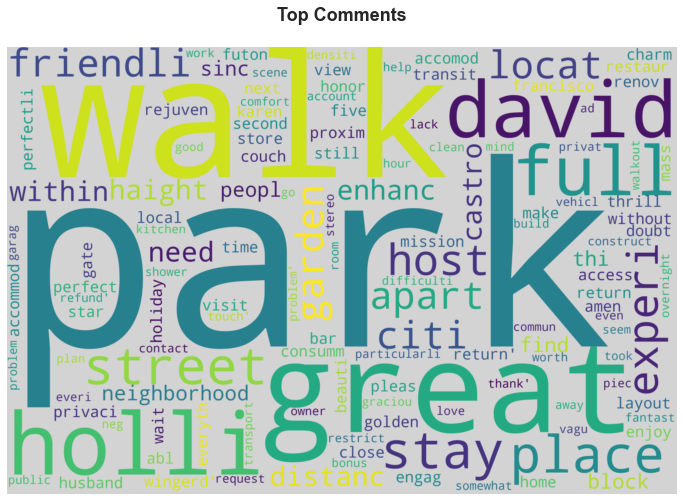

In [71]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(reviews.comments_cleansed.values))

plot_wordcloud(wordcloud, 'English')

In [68]:
my_stop_words = [" ".join(reviews.comments_cleansed[idx]) for idx in reviews.index]

In [49]:
print(my_stop_words[4])

holli place great exactli need perfect locat super clean even littl patio back sinc back francisco frequent good chanc make place come


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

custom_stop_words = []

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))

Created document-term matrix of size 298505 x 31810


In [53]:
from sklearn import decomposition
import numpy as np
nmf = decomposition.NMF(init = 'nndsvd', n_components = 5, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated W(document-topic)) matrix of size %s and H (topic-word) matrix of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()
n_top_words = 10

# Print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated W(document-topic)) matrix of size (298505, 5) and H (topic-word) matrix of size (5, 31810)
Topic #0:
the we it apart realli easi us park walk neighborhood

Topic #1:
host highli respons help commun beauti space home kind apart

Topic #2:
veri easi quiet space commun cozi neighborhood respons spaciou bed

Topic #3:
san francisco time fran home highli explor anyon trip we

Topic #4:
thi autom cancel post reserv arriv day the airbnb first



In [57]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,comments_cleansed,comments_cleaned
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",experi without doubt five star experi holli hu...,our experi without doubt five star experi holl...
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,return francisco rejuven thrill time enhanc st...,return san francisco rejuven thrill time enhan...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,pleas accommod friendli neighborhood be abl ma...,we pleas accommod friendli neighborhood be abl...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,highli recommend accomod agre previou post hol...,we highli recommend accomod agre previou post ...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,holli place great exactli need perfect locat s...,holli place great it exactli i need perfect lo...


In [54]:
mydf = pd.DataFrame({"feature_name": feature_names})

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

reviews_topic1 = []
reviews_topic2 = []
reviews_topic3 = []
reviews_topic4 = []
reviews_topic5 = []

for order_id, key, num1, num2, num3, num4, num5 in mylist:
    reviews_topic1.append((key, num1))
    reviews_topic2.append((key, num2))
    reviews_topic3.append((key, num3))
    reviews_topic4.append((key, num4))
    reviews_topic5.append((key, num5))

reviews_topic1 = sorted(reviews_topic1, key=lambda myword: myword[1], reverse=True)
reviews_topic2 = sorted(reviews_topic2, key=lambda myword: myword[1], reverse=True)
reviews_topic3 = sorted(reviews_topic3, key=lambda myword: myword[1], reverse=True)
reviews_topic4 = sorted(reviews_topic4, key=lambda myword: myword[1], reverse=True)
reviews_topic5 = sorted(reviews_topic5, key=lambda myword: myword[1], reverse=True)

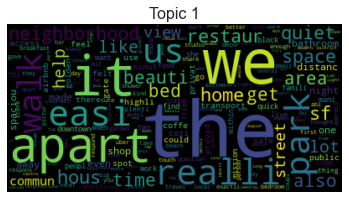

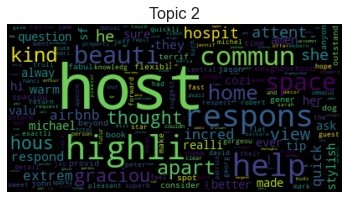

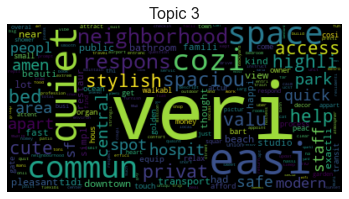

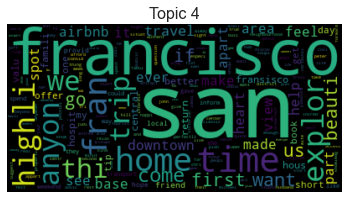

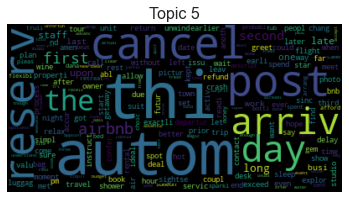

In [55]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline

def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    
    plt.title('Topic %s' %str(topic_number), size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

draw_wordcloud(dict(reviews_topic1), topic_number=1)
draw_wordcloud(dict(reviews_topic2), topic_number=2)
draw_wordcloud(dict(reviews_topic3), topic_number=3)
draw_wordcloud(dict(reviews_topic4), topic_number=4)
draw_wordcloud(dict(reviews_topic5), topic_number=5)

In [58]:
reviews.comments_cleansed.str.split(expand=True).stack().value_counts()[:30]

stay         201204
great        197922
place        181495
locat        124787
clean         98634
host          96100
room          75487
nice          73984
would         72746
recommend     72612
comfort       66779
love          61832
apart         59129
home          55122
walk          51498
everyth       51279
park          50872
need          50847
easi          50223
realli        48661
perfect       47629
time          46736
hous          45808
francisco     45584
well          44024
definit       43824
good          43500
citi          42495
space         41893
help          41420
dtype: int64

In [73]:
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [78]:
%%time

reviews['sentiment_neg'] = reviews['comments'].apply(negative_score)
reviews['sentiment_neu'] = reviews['comments'].apply(neutral_score)
reviews['sentiment_pos'] = reviews['comments'].apply(positive_score)
reviews['sentiment_compound'] = reviews['comments'].apply(compound_score)

Wall time: 31min 45s


In [84]:
df = reviews
df=df.drop(['reviewer_id'], axis=1)
df=df.drop(['reviewer_name'], axis=1)
df=df.drop(['date'], axis=1)

In [98]:
df.to_pickle("df_sentiment.pkl")

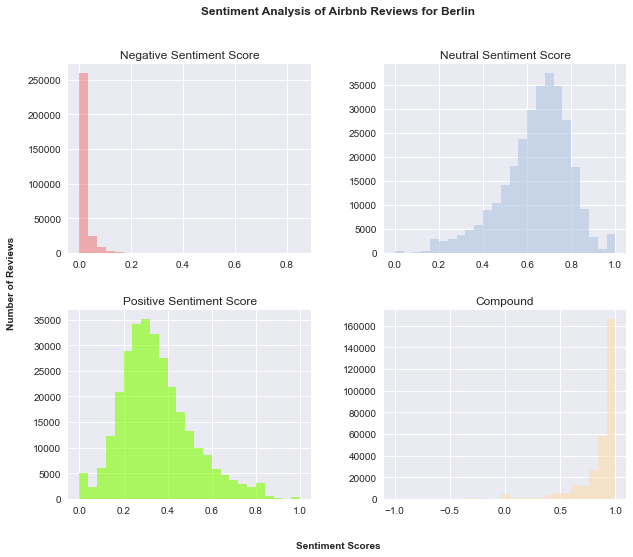

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')
df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')
df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')
df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of Airbnb Reviews for Berlin\n\n', fontsize=12, fontweight='bold');

In [87]:
percentiles = df.sentiment_compound.describe(percentiles=[.05, .1, .2, .3, .4, .5, .6, .7, .8, .9])
percentiles

count    298505.000000
mean          0.855578
std           0.218185
min          -0.997800
5%            0.457400
10%           0.636100
20%           0.801600
30%           0.868700
40%           0.907800
50%           0.932400
60%           0.950100
70%           0.963600
80%           0.974400
90%           0.984200
max           0.999700
Name: sentiment_compound, dtype: float64

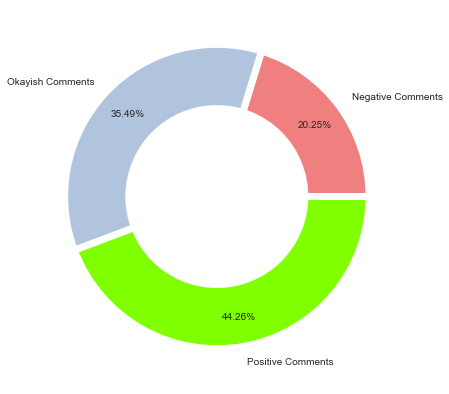

In [89]:
# assign the data
neg = percentiles['5%']
mid = percentiles['20%']
pos = percentiles['max']
names = ['Negative Comments', 'Neutral Comments','Positive Comments']
size = [neg, mid, pos]

# call a pie chart
plt.pie(size, labels=names, colors=['lightcoral', 'lightsteelblue', 'chartreuse'], 
        autopct='%.2f%%', pctdistance=0.8,
        wedgeprops={'linewidth':7, 'edgecolor':'white' })

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.show()

In [90]:
# full dataframe with POSITIVE comments
df_pos = df.loc[df.sentiment_compound >= 0.95]

# only corpus of POSITIVE comments
pos_comments = df_pos['comments'].tolist()

In [91]:
# full dataframe with NEGATIVE comments
df_neg = df.loc[df.sentiment_compound < 0.0]

# only corpus of NEGATIVE comments
neg_comments = df_neg['comments'].tolist()

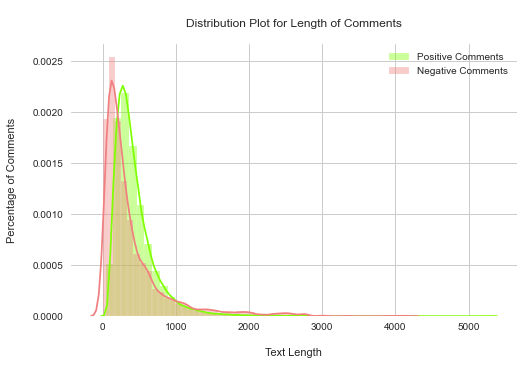

In [92]:
df_pos['text_length'] = df_pos['comments'].apply(len)
df_neg['text_length'] = df_neg['comments'].apply(len)
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df_pos['text_length'], kde=True, bins=50, color='chartreuse')
sns.distplot(df_neg['text_length'], kde=True, bins=50, color='lightcoral')

plt.title('\nDistribution Plot for Length of Comments\n')
plt.legend(['Positive Comments', 'Negative Comments'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');

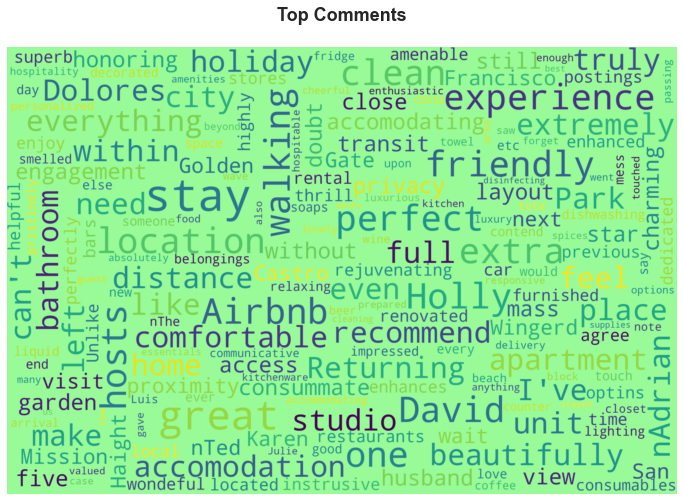

In [93]:
wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="white",
                      width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(df_pos.comments.values))

plot_wordcloud(wordcloud, '\nPositively Tuned')

In [99]:
# importing libraries
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette

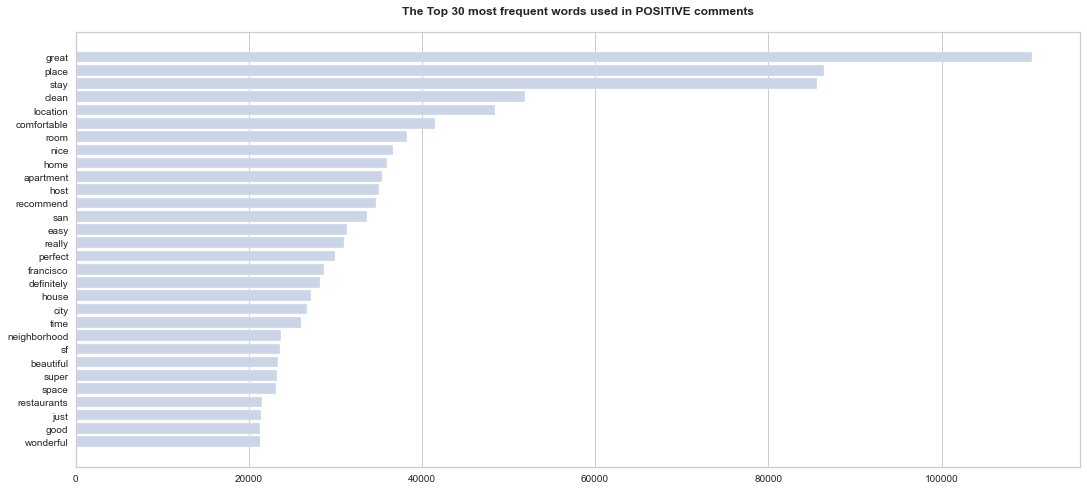

In [100]:
# vectorizing text
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(pos_comments)
features = vectorizer.get_feature_names()

# preparing the plot
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in POSITIVE comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;

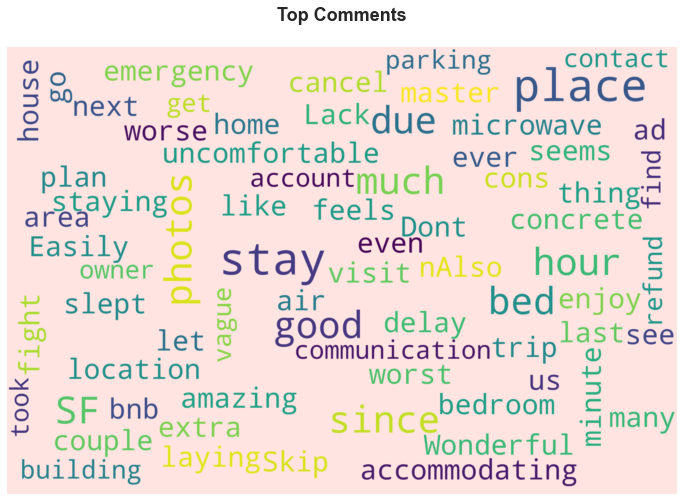

In [101]:
wordcloud = WordCloud(max_font_size=200, max_words=200, background_color="mistyrose",
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df_neg.comments.values))

plot_wordcloud(wordcloud, '\nNegatively Tuned')

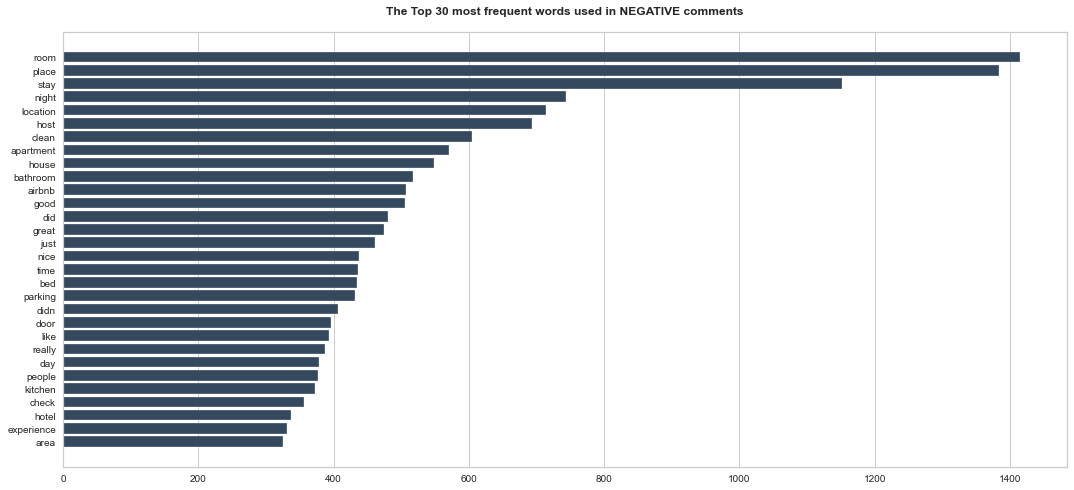

In [103]:
# vectorizing text
vectorizer = CountVectorizer(stop_words='english')
docs = vectorizer.fit_transform(neg_comments)
features = vectorizer.get_feature_names()

# preparing the plot
set_palette('flatui')
plt.figure(figsize=(18,8))
plt.title('The Top 30 most frequent words used in NEGATIVE comments\n', fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(docs)
visualizer.poof;